# Churn Down For What?

## Overview

(Client Redacted) approached our company, The Classification Station, to ascertain whether we could build a model to accurately predict whether a customer would "soon" stop doing business with (Client Redacted). When a customer withdraws their business, this is known as "churning".

## Business Understanding

While a certain amount of churn is unavoidable, businesses strive to bring churn to as low a level as possible. It is cheaper and thus more profitable to keep existing customers rather than lure in new ones. So, our company was employed to determined causes of churn and which of those causes had the most impact on (Client Redacted). Specifically, as we begin 2024, it is wise to keep in mind the changing social landscape around us. I do not know a single person without a cell phone unless they are a very young child, but I know many people without a landline, or only a cursory one that they got along with their internet or cable television package. Therefore, this project will continue under the assumption we are speaking of a cellular telephone company rather than one offering landline services.

## Data Understanding

This public dataset is provided by the CrowdAnalytix community as part of their churn prediction competition. The real name of the telecom company is anonymized. It contains 20 predictor variables mostly about customer usage patterns. There are 3333 records in this dataset, out of which 483 customers are churners and the remaining 2850 are non-churners. Thus, the ratio of churners in this dataset is 14%. Our first real steps at understanding our data, outside of the metadata we have, is performing a .head(), .describe() and .info() to see some basic statistics about our data.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Our first step is to pull in our data and do give it a cursory look-through, simply to see what we're working with.

In [3]:
cust_df = pd.read_csv("Data/bigml_59c28831336c6604c800002a.csv")

In [4]:
cust_df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Some very basic data exploration tells us that our dataframe contains information about customers, such as their state, length of account time, phone number, total minutes and charges, customer service calls, and whether they "churned". Recall that "churning" is to stop doing business with the company, so in this case, that column tells us whether the customer still does business with (Client Redacted). These explorations also tell us that we have 21 columns with 3333 entries each, and no null values. Furthermore, our data types include objects, integers, and one Boolean column.

One important thing to note was discussed earlier - in this dataset, only 14% of customers have "churned". We can see that here -

In [6]:
cust_df['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

This means that whilst we do have a binary classification problem on our hands, very suitable for logistic regression, we also have a class imbalance. Obviously, we will not be able to accurately predict anything with only 14% of a category of data available to us. This will need to eb dealt with as we progress through our data analysis and modeling.

Here, we determine which of these numeric columns have a correlation with our "churn" column, as that will eventually be our target when it comes time to model. A correlation of +/- 0.06 is considered notable, and as stated, we care about which columns are most strongly correlated (positively or negatively) with our "churn" column.

In [7]:
cust_df.corr()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
account length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
area code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
number vmail messages,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total day minutes,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total day calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total day charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total eve minutes,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total eve calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
total eve charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
total night minutes,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


One unfortunate caveat to this method of ascertaining correlation is that categorical columns, such as "state", will be ignored. This is because the .corr() function can only make use of numerical data. Still, it is a start, and our catagorical data correlation will be dealt with later as we establish a pipeline to do just that! In any case, this does tell us which of our numeric columns might be most useful to us as we begin to build our model (and our pipeline).

All that remains in our first exploratory steps within the wonderful world of our customer data is to make an action plan and perform a few last steps to enhance our understanding as we move into the preparation phase. As stated, I will be employing pipelines both to clean and prepare my training and testing data and to tune and evaluate the models fitted to that draining data. Therefore, I will discuss SMOTE, scaling, and encoding when I build the pipeline to perform these actions.

## Data Preparation

The very final step could also be performed in a pipeline, but I have chosen to do it manually for several reasons. First, dropping in a pipeline can cause trouble for OneHotEncoder, which I am planning to use. So in the interest of using my noodle ahead of time, I am simply going to perform this manually. As a selfish little aside, I also want to display that I've learned how to drop columns better since phase one thank you.

In [8]:
cust_df = cust_df.drop(['area code', 'phone number', 'voice mail plan', 'total day calls', 'total eve calls', 'total night calls', 'total intl calls'], axis=1)

In [9]:
cust_df

,state,account length,international plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge,customer service calls,churn
0,KS,128,no,25,265.1,45.07,197.4,16.78,244.7,11.01,10.0,2.70,1,False
1,OH,107,no,26,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70,1,False
2,NJ,137,no,0,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29,0,False
3,OH,84,yes,0,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78,2,False
4,OK,75,yes,0,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,36,156.2,26.55,215.5,18.32,279.1,12.56,9.9,2.67,2,False
3329,WV,68,no,0,231.1,39.29,153.4,13.04,191.3,8.61,9.6,2.59,3,False
3330,RI,28,no,0,180.8,30.74,288.8,24.55,191.9,8.64,14.1,3.81,2,False
3331,CT,184,yes,0,213.8,36.35,159.6,13.57,139.2,6.26,5.0,1.35,2,False


As we can see, we've dropped several columns I feel are irrelevant. I don't feel that a person's area code or phone number would influence their decision to leave a cell phone provider, specifically. As a matter of fact, one of the most famous phone numbers of all time (867-5309) was last sold in 2009 for upwards of 365,000. Customers are far more likely to request a simple (and usually free with good reason) phone number change rather than churn.

Additionally, according to the available data, voice mail plans do not cost the customer any extra, and so I do not believe the correlation would be high enough to keep it in as a later feature for our model. I also included the number of voice mail messages, which I feel would get the same point across whether the customer had a voice mail plan or not. Similarly, I felt that all of the data contained within number of calls dependent on time of day or international was also contained within the minutes columns, and so chose to keep those instead.

Since we are modeling (and testing that model), our first step will always be to complete a train/test split. Data leakage is a very serious concern in machine learning, because our models are trained on a set of data and then tested on another set that is supposed to have remained unseen during the training phase. Data leakage occurs when that is not the case, and the model has been "trained" on "testing" data. This is disingenuous and skews results, so it is of the utmost importance that we prevent said data leakage.

In [10]:
X = cust_df.drop('churn', axis=1)
y = cust_df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [11]:
X_train

,state,account length,international plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge,customer service calls
367,MD,45,no,0,78.2,13.29,253.4,21.54,255.0,11.48,18.0,4.86,1
3103,DE,115,no,0,195.9,33.30,227.0,19.30,313.2,14.09,13.2,3.56,2
549,OK,121,no,31,237.1,40.31,205.6,17.48,196.7,8.85,10.1,2.73,4
2531,RI,180,no,0,143.3,24.36,180.5,15.34,184.2,8.29,10.1,2.73,1
2378,OR,112,no,0,206.2,35.05,164.5,13.98,140.3,6.31,12.6,3.40,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,ID,106,no,0,274.4,46.65,198.6,16.88,160.8,7.24,6.0,1.62,1
1130,PA,122,no,0,35.1,5.97,180.8,15.37,251.6,11.32,12.7,3.43,1
1294,OR,66,no,0,87.6,14.89,262.0,22.27,184.6,8.31,9.2,2.48,1
860,HI,169,no,0,179.2,30.46,175.2,14.89,228.6,10.29,9.9,2.67,2


In [12]:
X_test

,state,account length,international plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge,customer service calls
438,WY,113,no,0,155.0,26.35,330.6,28.10,189.4,8.52,13.5,3.65,1
2674,IL,67,no,0,109.1,18.55,217.4,18.48,188.4,8.48,12.8,3.46,0
1345,SD,98,no,0,0.0,0.00,159.6,13.57,167.1,7.52,6.8,1.84,4
1957,KY,147,no,0,212.8,36.18,204.1,17.35,156.2,7.03,10.2,2.75,1
2148,WY,96,no,0,144.0,24.48,224.7,19.10,227.7,10.25,10.0,2.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,NY,171,no,0,137.5,23.38,198.1,16.84,292.7,13.17,13.3,3.59,2
1586,CT,89,no,0,82.3,13.99,167.2,14.21,194.7,8.76,7.2,1.94,1
3068,SC,78,no,21,160.6,27.30,223.1,18.96,124.0,5.58,9.5,2.57,2
2484,IN,141,no,39,116.9,19.87,276.5,23.50,289.9,13.05,12.3,3.32,0


As we can see, our data has now been split into a training and a testing set. The testing set will be set aside and will not be touched until it is time to test the final model on that testing data. When that time comes, I will use the data cleaning pipeline I am about to build in order to scale and encode the testing data in the same way it will do to the training data. Technically, the train/test split step could have been performed in the cleaning pipeline as well, but I preferred to do it myself and ensure that the testing data was properly set aside and untouched throughout the process.

Finally, with all these beginning steps completed, we can build a pipeline to get to the true meat of our data preparation.

In [13]:
num_feats = ['account length', 'number vmail messages', 'total day minutes', 'total day charge', 'total eve minutes', 'total eve charge', 'total night minutes', 'total night charge', 'total intl minutes', 'total intl charge', 'customer service calls']
cat_feats = ['state', 'international plan']

In [14]:
standard_pipeline = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('numeric', StandardScaler(), num_feats)
    ],
    remainder='passthrough')

In [15]:
standard_pipeline.fit_transform(X_train)

<2499x64 sparse matrix of type '<class 'numpy.float64'>'
	with 32487 stored elements in Compressed Sparse Row format>

In [16]:
standard_pipeline.transform(X_test)

<834x64 sparse matrix of type '<class 'numpy.float64'>'
	with 10842 stored elements in Compressed Sparse Row format>

Now, both our testing and training data have had the same transformations performed upon them, in the exact same way. The next step is to build what is known as a "dummy model" that will always predict "yes". As in, "yes", the customer will "soon" stop doing business with (Client Redacted). Then, we will evaluate that model against the available data to see how "accurate" it was in predicting whether or not a customer would churn.

In [17]:
y.value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

Recall that our data has a class imbalance. We will first be modeling and analyzing this data without addressing that class imbalance, to see what results we can glean from that in context of later tuning a better fitting model after having addressed the class imbalance. It will allow us to see the differences in our preparation processes and whether those have an impact on our model performance.

## Analysis

In [18]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [19]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [20]:
dummy_model.predict(X_train)[:50]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

The dummy model has taken the most frequent value found in the target column of "churn", which in this case is "false", and has predicted that a customer will not churn for every customer, regardless. Let's see how "accurate" the dummy model is when tested.

In [21]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.8567430861723446

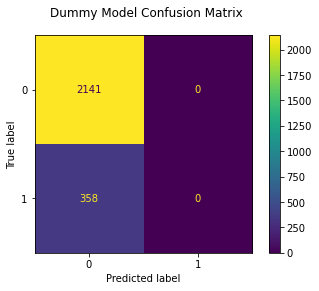

In [22]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, dummy_model.predict(X_train))).plot(ax=ax)

The dummy model is 85% accurate, meaning that customers will not churn 85% of the time. This isn't exactly a great score, but it isn't the worst score, either. Let's try a simple logistic regression model and see if we can do a better job than simply predicting the most common response every time. This will be done in a pipeline, for the sake of data leakage and proper procedure, which is not fully necessary with a dummy model.

In [23]:
y_pred_dummy_train = dummy_model.predict(X_train)
y_pred_dummy_test = dummy_model.predict(X_test)

In [24]:
y_pred_dummy_train

array([False, False, False, ..., False, False, False])

In [25]:
y_pred_dummy_test

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [26]:
accuracy_score(y_train, y_pred_dummy_train), accuracy_score(y_test, y_pred_dummy_test)

(0.8567426970788315, 0.8501199040767387)

In [27]:
recall_score(y_train, y_pred_dummy_train), recall_score(y_test, y_pred_dummy_test)

(0.0, 0.0)

In [28]:
cross_val_score(dummy_model, X_train, y_train).mean()

0.8567430861723446

In [29]:
cross_val_score(dummy_model, X_train, y_train, scoring='recall').mean()

0.0

In [30]:
log_pipe1 = Pipeline(steps=[('ct', standard_pipeline),
                          ('logreg', LogisticRegression(random_state=42, penalty='none'))])

In [31]:
log_pipe1.fit(X_train, y_train)

C:\Users\rac753\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state',
                                                   'international plan']),
                                                 ('numeric', StandardScaler(),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve charge',
                                                   'total night minutes',
                                           

Do not despair! Now is the time to hypertune our logistic regression model to ensure proper performance, which we will do in the following cells.

In [32]:
log_pipe2 = Pipeline(steps=[('ct', standard_pipeline),
                          ('logreg', LogisticRegression(random_state=42, penalty='none',
                                                       max_iter = 1000))])

In [33]:
log_pipe2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state',
                                                   'international plan']),
                                                 ('numeric', StandardScaler(),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve charge',
                                                   'total night minutes',
                                           

In [34]:
log_pipe2.score(X_train, y_train)

0.8687474989995998

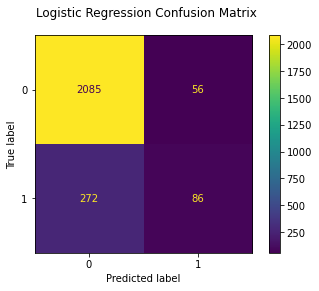

In [35]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe2.predict(X_train))).plot(ax=ax)

This model did perform slightly better, with an 87% accuracy rating rather than 85%, but it's still not performing especially well. Perhaps we can tune it to tweak its performance. Recall that we have applied no regularization to these logistic regression models, as seen where the code displays penalty='none'. It is advised to begin with L2 (Ridge) regularization, and so that is where we will begin as well.

In [36]:
y_pred_log_train = log_pipe2.predict(X_train)

In [37]:
y_pred_log_test = log_pipe2.predict(X_test)

In [38]:
accuracy_score(y_train, y_pred_log_train), accuracy_score(y_test, y_pred_log_test)

(0.8687474989995998, 0.8525179856115108)

In [39]:
recall_score(y_train, y_pred_log_train), recall_score(y_test, y_pred_log_test)

(0.24022346368715083, 0.2)

In [40]:
cross_val_score(log_pipe2, X_train, y_train).mean()

0.8563430861723447

In [41]:
cross_val_score(log_pipe2, X_train, y_train, scoring='recall').mean()

0.2096635367762128

In [42]:
log_pipe3 = Pipeline(steps=[('ct', standard_pipeline),
                          ('logreg', LogisticRegression(random_state=42, penalty='l2',
                                                       max_iter = 1000))])

In [43]:
log_pipe3.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state',
                                                   'international plan']),
                                                 ('numeric', StandardScaler(),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve charge',
                                                   'total night minutes',
                                           

In [44]:
log_pipe3.score(X_train, y_train)

0.867547018807523

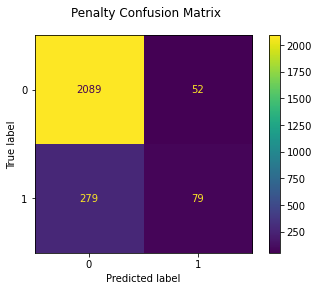

In [45]:
fig, ax = plt.subplots()

fig.suptitle("Penalty Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe3.predict(X_train))).plot(ax=ax)

In [46]:
y_pred_log_train_3 = log_pipe3.predict(X_train)

In [47]:
y_pred_log_test_3 = log_pipe3.predict(X_test)

In [48]:
accuracy_score(y_train, y_pred_log_train_3), accuracy_score(y_test, y_pred_log_test_3)

(0.867547018807523, 0.854916067146283)

In [49]:
recall_score(y_train, y_pred_log_train_3), recall_score(y_test, y_pred_log_test_3)

(0.2206703910614525, 0.2)

In [50]:
cross_val_score(log_pipe3, X_train, y_train).mean()

0.856343887775551

In [51]:
cross_val_score(log_pipe3, X_train, y_train, scoring='recall').mean()

0.19843505477308293

Let's assume that 87% is the best we can do with this logistic regression model, and try attacking this from a different perspective. Another issue we had with our data, as you'll recall, was a class imbalance, meaning that only 14% of the customers in this dataset had churned, and so it would be difficult to make assumptions as to why with so little data available. 

In [52]:
log_pipe4 = Pipeline(steps=[('ct', standard_pipeline),
                          ('logreg', LogisticRegression(random_state=42, penalty='l2',
                                                       max_iter = 1000, class_weight = 'balanced'))])

In [53]:
log_pipe4.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state',
                                                   'international plan']),
                                                 ('numeric', StandardScaler(),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve charge',
                                                   'total night minutes',
                                           

In [54]:
log_pipe4.score(X_train, y_train)

0.7743097238895558

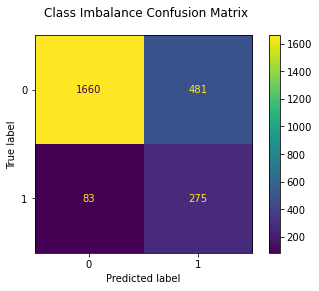

In [55]:
fig, ax = plt.subplots()

fig.suptitle("Class Imbalance Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe4.predict(X_train))).plot(ax=ax)

In [56]:
y_pred_log_train_4 = log_pipe4.predict(X_train)

In [57]:
y_pred_log_test_4 = log_pipe4.predict(X_test)

In [58]:
accuracy_score(y_train, y_pred_log_train_4), accuracy_score(y_test, y_pred_log_test_4)

(0.7743097238895558, 0.7841726618705036)

In [59]:
recall_score(y_train, y_pred_log_train_4), recall_score(y_test, y_pred_log_test_4)

(0.7681564245810056, 0.776)

As we can see, our accuracy and recall have stayed roughly the same regardless of what we've tried. Now, our main focus is actually recall, with a backup focus on accuracy as the class imbalance can lead to some issues in the 'accuracy' area. Thus, our main focus is recall, in which we are doing terribly. Now, we will try to perform a grid search that will enable us to define the best hyperparameters to achieve the best recall possible.

Now, we must cross-validate our model to ensure we're reporting accurate performance.

In [60]:
cross_val_score(log_pipe4, X_train, y_train).mean()

0.7671094188376755

In [61]:
cross_val_score(log_pipe4, X_train, y_train, scoring='recall').mean()

0.7291862284820031

In [62]:
log_pipe4.named_steps['logreg'].coef_

array([[-4.20500865e-01, -1.05004157e+00,  1.70037858e-01,
        -5.92340507e-01,  9.12553667e-01, -2.47908734e-01,
        -3.01624124e-02,  2.40202644e-01, -1.46032686e-01,
         1.59326160e-01,  2.03505368e-01, -7.67428284e-01,
        -9.35953944e-01, -2.84143669e-01, -7.88287308e-01,
         1.18534066e-01,  2.58369185e-01,  7.32233542e-02,
        -1.10522438e-01,  1.36528892e-01,  3.64444264e-01,
         6.20796129e-01,  1.46840022e-01,  3.59549215e-01,
        -4.33905507e-01,  7.97427964e-01,  9.62104540e-01,
         1.59927806e-01, -1.00676068e+00,  2.20632153e-01,
        -1.81272069e-01,  6.38414500e-01, -2.07613506e-01,
         4.00098468e-01,  3.23620976e-01,  2.45227624e-01,
         1.37761338e-03,  3.04021525e-01,  6.10871185e-01,
        -3.62199858e-01,  7.65537444e-01, -1.42216683e-01,
        -3.87195101e-01,  7.17190525e-01, -1.22924627e-03,
        -7.20588981e-01, -8.80698889e-01,  3.68587607e-01,
        -2.42599870e-01, -3.68478004e-02, -2.99938196e-0

## Model Recommendation

Per our cross_val_scores, our final model was a logistic regression with an L2 penalty and a class weight of balanced. Said final model achieved a recall of 73% and an accuracy of 77%. These numbers may be able to be improved with more time and/or resources.

## Conclusion

Though our final model was not our most accurate, it did have the highest recall we could facilitate. Recall was our most important metric because it measures, in this context, which customers actually churned versus predicted churns.


## Next Steps

A possible next course of action would be for (Client Redacted) to earmark customers with a certain threshold of customer service calls and use our model to predict those that will churn based upon that. Then, (Client Redacted) can take advantage of the proffered opportunity to prevent that customer from churning.